<h1><center>Data Analysis</center></h1>
<h2><center>Kaggle report notebook</center></h2>

# Introduce yourself

Put your team name and team-members' names below

Казанцева Анастасия, БПИ162

Полудницин Александр, БПИ162

Уткин Дмитрий, БПИ161

# Вспомогательные функции, импорты

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns;
from sklearn.decomposition import TruncatedSVD

In [15]:
def save_solution(ids, scores, file_name):
    pd.DataFrame(data={'product_id': ids, 'score': scores}).to_csv(file_name, index=None)

In [12]:
def unique_values_bars(data, feature_name, n_top=None, with_sold_fast=True):
    
    # Feature values
    feature_values = data[feature_name].values

    if with_sold_fast:
        # Target labels
        labels = data['sold_fast'].values

    # Unique values
    unique, counts = np.unique(feature_values, return_counts=True)
    
    print("Number of unique values: ", len(unique))
    
    if n_top is None:
        n_top = 10**6
        
    unique_1 = unique[counts.argsort()][-n_top:]
    counts_1 = counts[counts.argsort()][-n_top:]
        
    plt.figure(figsize=(9, 0.25 * len(unique_1)))
    plt.barh(y=range(len(unique_1)), width=counts_1)
    plt.yticks(range(len(unique_1)), unique_1, size=14)
    plt.xticks(size=14)
    plt.ylabel('Feature value', size=14)
    plt.xlabel('Number of values', size=14)
    plt.grid(b=1)
    plt.show()

    if with_sold_fast:
        probas = []
        for aval in unique:
            labels_for_val = labels[feature_values == aval]
            n = len(labels_for_val)
            n_1 = len(labels_for_val[labels_for_val == 1])
            p = 1.0 * n_1 / n
            probas.append(p)
        probas = np.array(probas)


        unique_2 = unique[probas.argsort()][-n_top:]
        probas_2 = probas[probas.argsort()][-n_top:]

        plt.figure(figsize=(9, 0.25 * len(unique_2)))
        plt.barh(y=range(len(unique_2)), width=probas_2)
        plt.yticks(range(len(unique_2)), unique_2, size=14)
        plt.xticks(size=14)
        plt.ylabel('Feature value', size=14)
        plt.xlabel('Probability to be sold (class 1)', size=14)
        plt.grid(b=1)
        plt.show()

In [17]:
def estimate_result(y_test, y_pred):
    classes = pd.Series([0, 1]) 
    
    print('Accuracy', (np.array(y_test) == list(y_pred)).sum() / len(y_test))
    
    print('\n')
    
    for clas in classes:
        print('Recall', clas, '\t', ((np.array(y_test) == clas) * (np.array(y_test) == list(y_pred))).sum() / y_test.value_counts()[clas])
        
    print('\n')
    
    for clas in classes:
        print('Precision', clas, '\t', ((np.array(y_test) == clas) * (np.array(y_test) == list(y_pred))).sum() / (np.array(y_pred) == clas).sum())
    
    print('\n')
    
    print('F-мера', f1_score(np.array(y_test), np.array(y_pred), average=None))
    
    print('\n')
    
    print('Матрица ошибок:')
    
    sns.set()
    sns.heatmap(confusion_matrix(y_test, y_pred),cmap="YlGnBu", annot=True)

In [18]:
def estimate_result_2(y_test, y_pred, class_prefix = ''):
    classes = class_prefix + pd.Series(['0', '1']) 
    
    print('Accuracy', (np.array(y_test) == list(y_pred)).sum() / len(y_test))
    
    print('\n')
    
    for clas in classes:
        print('Recall', clas, '\t', ((np.array(y_test) == clas) * (np.array(y_test) == list(y_pred))).sum() / y_test.value_counts()[clas])
        
    print('\n')
    
    for clas in classes:
        print('Precision', clas, '\t', ((np.array(y_test) == clas) * (np.array(y_test) == list(y_pred))).sum() / (np.array(y_pred) == clas).sum())
    
    print('\n')
    
    print('F-мера', f1_score(np.array(y_test), np.array(y_pred), average=None))
    
    print('\n')
    
    print('Матрица ошибок:')
    
    sns.set()
    sns.heatmap(confusion_matrix(y_test, y_pred),cmap="YlGnBu", annot=True)

In [19]:
def get_top_labels(data, feature_name, n_top):
    feature_values = data[feature_name].values
    unique, counts = np.unique(feature_values, return_counts=True)
    return unique[counts.argsort()][-n_top:]

# Task

In this task we are working with posts on famous russian advertisement and resell platform.

Ginen information about the post and corresponding item you have to estimate its probability to be sold in 3 days.

Below you will find some desirable stages of your report.

# Data Loading

In [13]:
df_train = pd.read_csv('./train.tsv', sep='\t', index_col=0)
df_test = pd.read_csv('./test_nolabel.tsv', sep='\t', index_col=0)

In [21]:
len(df_train.columns)

19

In [22]:
df_train.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
1,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,1
2,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,0
4,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,0
6,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,0
10,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0


# Descriptive Data Analysis

* Analyze train dataset features
    * Provide some meaningfull description about corresponding features (in form of pictures or some coefficients)
    * Outline any findings you are able to reveal
* Try to measure analyse any correspondense between features and target features

## Займемся анализом и подготовкой данных

Используя https://github.com/hushchyn-mikhail/kaggle_hse_fastsold/blob/master/research/DataStudy.ipynb

(Для каждой фичи предложены несколько вариантов обработки, какие именно фичи используются в том или ином варианте обучения - уточняется около моделей(преимущественно около хороших:) ))

In [12]:
# Узнаем процентное соотношение положительных классов и отрицательных
labels = df_train['sold_fast'].values
n_1 = len(labels[labels == 1])
n_0 = len(labels[labels == 0])
n_1 / (n_0 + n_1)

0.23081236958446372

23% положительных класса при 70+% отрицательных - чаще товары не продаются в первые 3 дня.

In [20]:
print("Количество уникальных значений для:")
for feature_name in df_train.columns:
    # Feature values
    feature_values = df_train[feature_name].values
    # Target labels
    labels = df_train['sold_fast'].values
    # Unique values
    unique, counts = np.unique(feature_values, return_counts=True)
    print('\t' +feature_name+": ", len(unique),'\t', type(df_train[feature_name].values[0]))

Количество уникальных значений для:
	category_id:  24 		 <class 'numpy.int64'>
	city:  2299 		 <class 'str'>
	date_created:  289 		 <class 'str'>
	delivery_available:  2 		 <class 'numpy.bool_'>
	desc_text:  333976 		 <class 'str'>
	img_num:  20 		 <class 'numpy.int64'>
	lat:  74798 		 <class 'numpy.float64'>
	long:  109704 		 <class 'numpy.float64'>
	name_text:  212239 		 <class 'str'>
	owner_id:  305336 		 <class 'str'>
	payment_available:  2 		 <class 'numpy.bool_'>
	price:  2861 		 <class 'numpy.float64'>
	product_id:  351281 		 <class 'str'>
	product_type:  3 		 <class 'numpy.int64'>
	properties:  89835 		 <class 'str'>
	region:  109 		 <class 'str'>
	sold_mode:  2 		 <class 'numpy.int64'>
	subcategory_id:  281 		 <class 'numpy.int64'>
	sold_fast:  2 		 <class 'numpy.int64'>


Пройдем по всем признакам и преобразуем.

Все числовые признаки оставим без изменений:

	img_num:  20
    lat:  74798
    long:  109704
    price:  2861 
    sold_mode:  2

А булевы признаки приведем к числу:

    delivery_available:  2
    payment_available:  2

Категориальные разделим на числовые бинарные:

    category_id:  24
    city:  2299
    region:  109 
    product_type:  3
    subcategory_id:  281

Остаются:

        * date_created:  289 - переведем в число от начала 2018 года
        * name_text:  212239 - преобразуем в вектор
        * owner_id:  305336 - посмотрим на корелляцию между продавцом и быстротой продажи и возможно не возьмем в рассмотрение
        * product_id:  351281 - выкинем уникальный признак
        * properties:  89835 - похоже на JSON. Посмотрим на его значения и решим что делать
        * desc_text:  333976 - применим классификацию отдельно

### Создадим новый датасет, в котором будут храниться только обработанные данные

Данные фичи используются в каждой модели.

In [23]:
df_train_prep = pd.DataFrame()
df_test_prep = pd.DataFrame()
for feature_name in ['img_num', 'lat', 'long', 'price', 'sold_mode']:
    df_train_prep[feature_name] = df_train[feature_name]
    df_test_prep[feature_name] = df_test[feature_name]
    
df_train_y = df_train['sold_fast']

### Приведем булевы признаки к числам

Данные фичи используются в каждой модели.

In [24]:
for feature_name in ['delivery_available', 'payment_available']:
    df_train_prep[feature_name] = df_train[feature_name].map(int)
    df_test_prep[feature_name] = df_test[feature_name].map(int)

### category_id

Данный вариант обработки фичи используются в каждой модели.

Number of unique values:  24


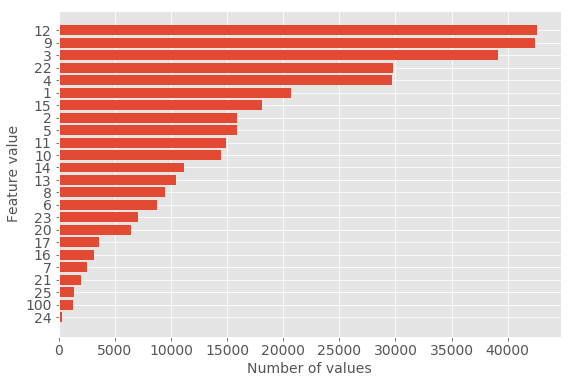

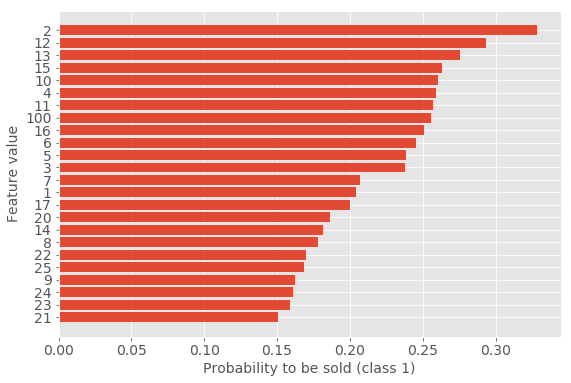

In [14]:
unique_values_bars(df_train, feature_name='category_id')

Number of unique values:  24


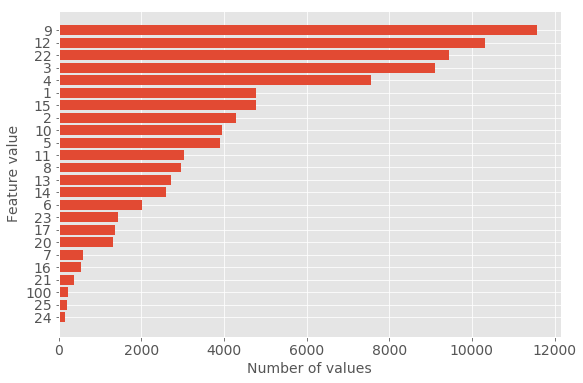

In [18]:
unique_values_bars(df_test, feature_name='category_id', n_top=100, with_sold_fast=False)

Распределение частот категорий похожее

In [25]:
# Превратим все эти признаки в бинарные. Исключим преобразование только 1 категории, дабы избежать линейной зависимости
for feature_name in get_top_labels(df_train, 'category_id', 23):
    df_train_prep['category_id: ' + str(feature_name)] = (df_train['category_id'] == feature_name).map(int)
    df_test_prep['category_id: ' + str(feature_name)] = (df_test['category_id'] == feature_name).map(int)

### city

Данный вариант обработки фичи используется в каждой модели.

Number of unique values:  2299


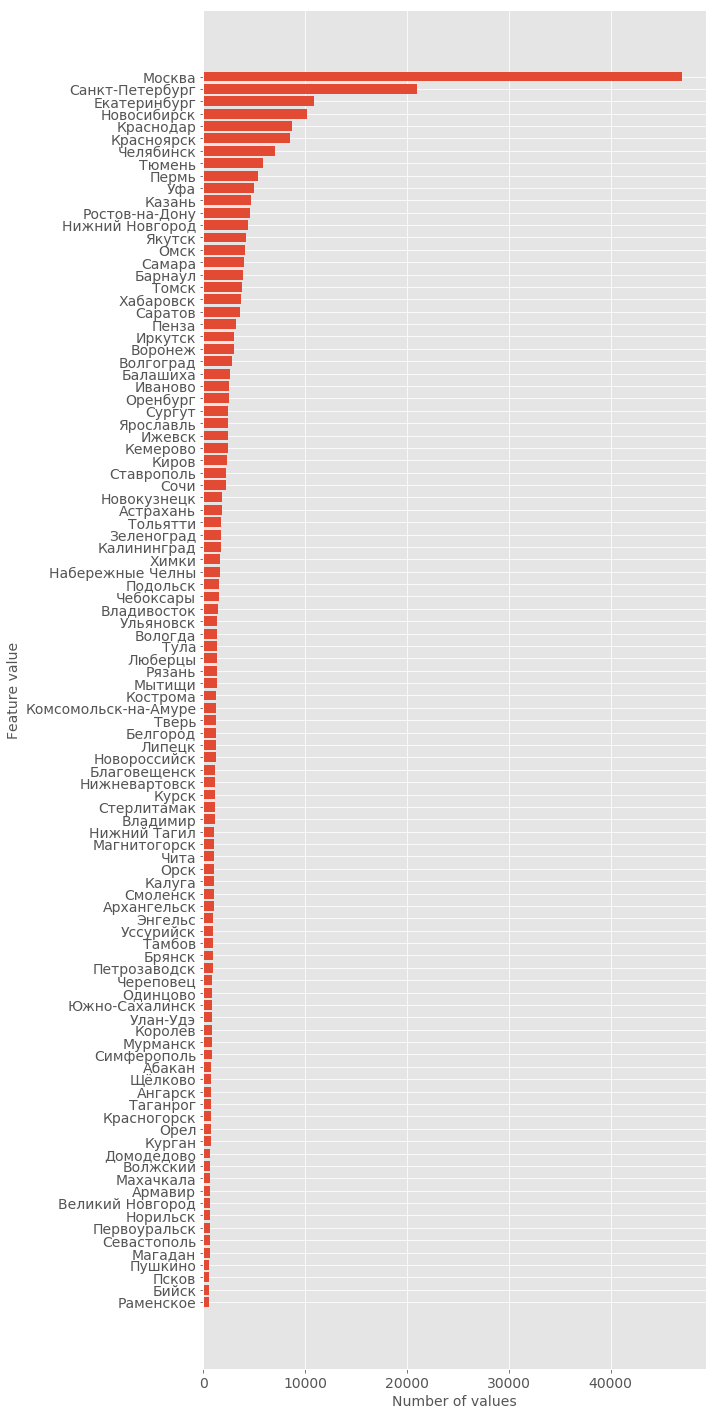

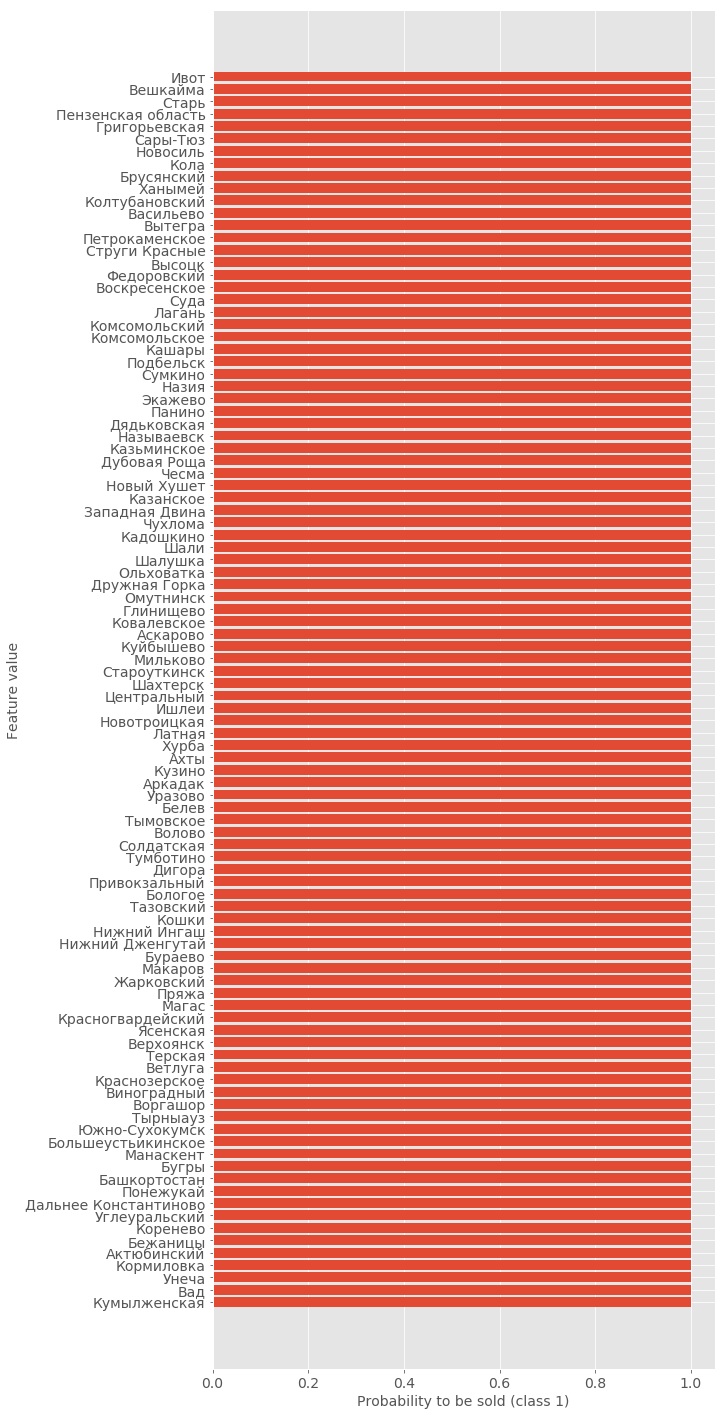

In [29]:
unique_values_bars(df_train, feature_name='city', n_top=100)

Number of unique values:  1558


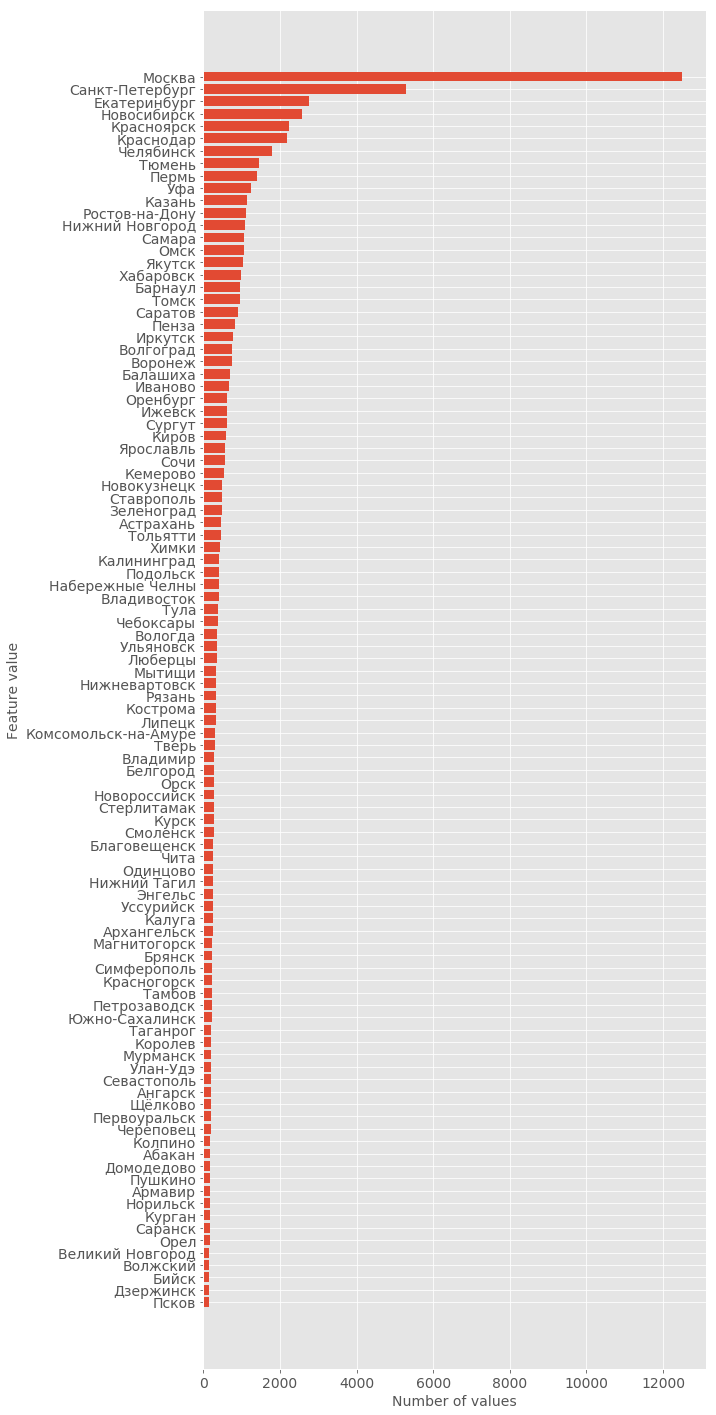

In [34]:
unique_values_bars(df_test, feature_name='city', n_top=100, with_sold_fast=False)

Для обучающей и тестовой выборки характерно одинаковое распределение.

In [26]:
# Превратим топ 10 городов в бинарные признаки
for feature_name in get_top_labels(df_train, 'city', 10):
    df_train_prep['city: ' + feature_name] = (df_train['city'] == feature_name).map(int)
    df_test_prep['city: ' + feature_name] = (df_test['city'] == feature_name).map(int)

### date_created

Попробуем преобразовать дату в день недели и месяц. Этот код в участвует не во всех решениях.

In [28]:
splitted_date_train = pd.to_datetime(df_train['date_created']).apply(lambda t: t.weekday())
splitted_date_test = pd.to_datetime(df_test['date_created']).apply(lambda t: t.weekday())

In [33]:
for feature_name in [0,1,2,3,4,5,6]:
    df_train_prep['weekday: ' + str(feature_name)] = (splitted_date_train == feature_name).map(int)
    df_test_prep['weekday: ' + str(feature_name)] = (splitted_date_test == feature_name).map(int)

In [36]:
splitted_date_train = pd.to_datetime(df_train['date_created']).apply(lambda t: t.month)
splitted_date_test = pd.to_datetime(df_test['date_created']).apply(lambda t: t.month)

In [43]:
for feature_name in [2,3,4,5,6,7,8,9,10,11,12]:
    df_train_prep['month: ' + str(feature_name)] = (splitted_date_train == feature_name).map(int)
    df_test_prep['month: ' + str(feature_name)] = (splitted_date_test == feature_name).map(int)

Преобразуем дату во время от начала 2018, что сложноинтерпретируемо моделями. Этот код в участвует не во всех решениях.

In [12]:
def date_formatter(date):
    splitted_date = list(map(int, date.split('-')))
    if splitted_date[0] != 2018:
        raise Exception('Год на который мы не расчитывали' + splitted_date[0])
        
    return (splitted_date[1] - 1) * 30 + splitted_date[2]

In [13]:
splitted_date_train = df_train['date_created'].map(date_formatter)
splitted_date_test = df_test['date_created'].map(date_formatter)

In [14]:
df_train_prep['date_created'] = splitted_date_train
df_test_prep['date_created'] = splitted_date_test

### owner_id

Данная фича не используется ни в одной модели.

Number of unique values:  305336


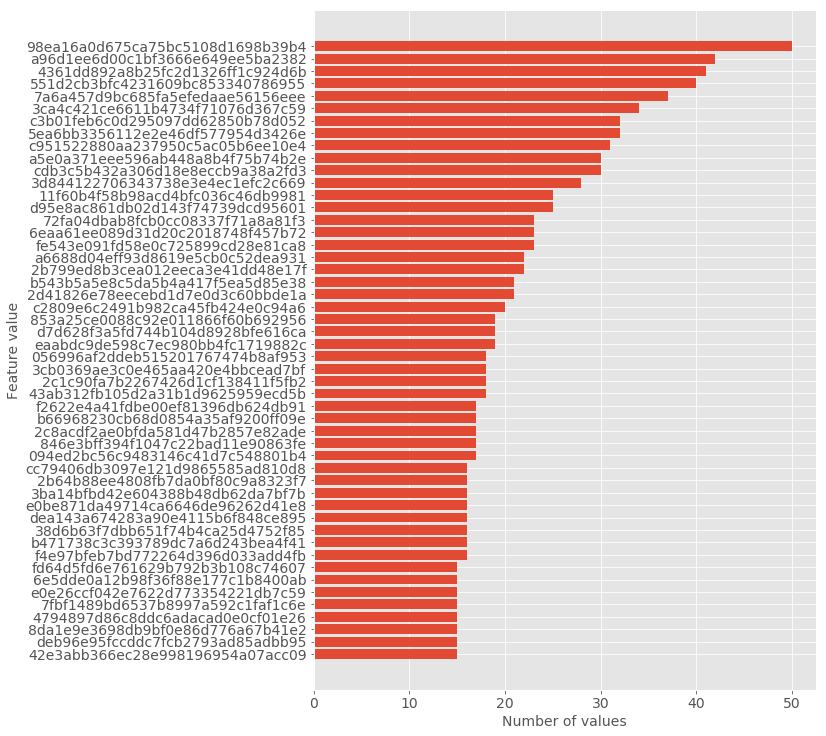

KeyboardInterrupt: 

In [81]:
unique_values_bars(df_train, feature_name='owner_id', n_top=50)

In [87]:
# Рассмотрим процент sold_fast-продаж среди продавцов, которые чаще всего продают.
for owner in get_top_labels(df_train, 'owner_id', 50):
    vals = df_train[df_train['owner_id'] == owner]
    print(owner, '\t', vals['sold_fast'].sum() / len(vals['sold_fast']))

42e3abb366ec28e998196954a07acc09 	 0.0
deb96e95fccddc7fcb2793ad85adbb95 	 0.4666666666666667
8da1e9e3698db9bf0e86d776a67b41e2 	 0.4
4794897d86c8ddc6adacad0e0cf01e26 	 0.4666666666666667
7fbf1489bd6537b8997a592c1faf1c6e 	 0.0
e0e26ccf042e7622d773354221db7c59 	 0.4
6e5dde0a12b98f36f88e177c1b8400ab 	 0.0
fd64d5fd6e761629b792b3b108c74607 	 0.3333333333333333
f4e97bfeb7bd772264d396d033add4fb 	 0.4375
b471738c3c393789dc7a6d243bea4f41 	 0.375
38d6b63f7dbb651f74b4ca25d4752f85 	 0.25
dea143a674283a90e4115b6f848ce895 	 0.25
e0be871da49714ca6646de96262d41e8 	 0.1875
3ba14bfbd42e604388b48db62da7bf7b 	 0.375
2b64b88ee4808fb7da0bf80c9a8323f7 	 0.25
cc79406db3097e121d9865585ad810d8 	 0.1875
094ed2bc56c9483146c41d7c548801b4 	 0.0
846e3bff394f1047c22bad11e90863fe 	 0.35294117647058826
2c8acdf2ae0bfda581d47b2857e82ade 	 0.17647058823529413
b66968230cb68d0854a35af9200ff09e 	 0.29411764705882354
f2622e4a41fdbe00ef81396db624db91 	 0.058823529411764705
43ab312fb105d2a31b1d9625959ecd5b 	 0.2222222222222222
2

Судя по полученным выше данным - от продавца получаемая метрика вряд ли будет зависеть. Не будем включать ее далее

### region

Данный вариант обработки фичи используется в каждой модели.

Number of unique values:  109


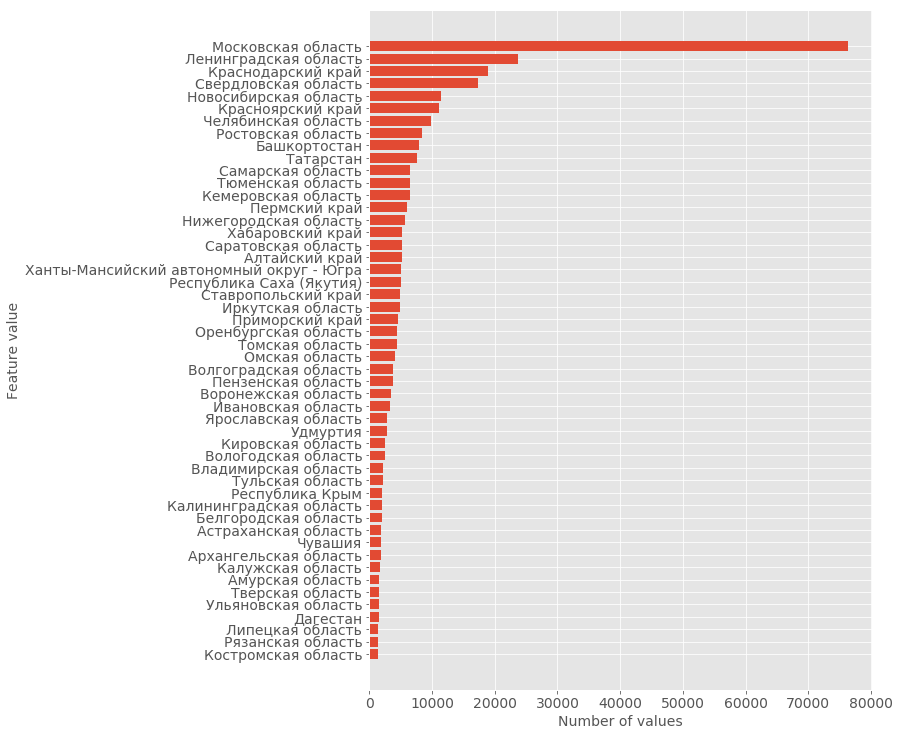

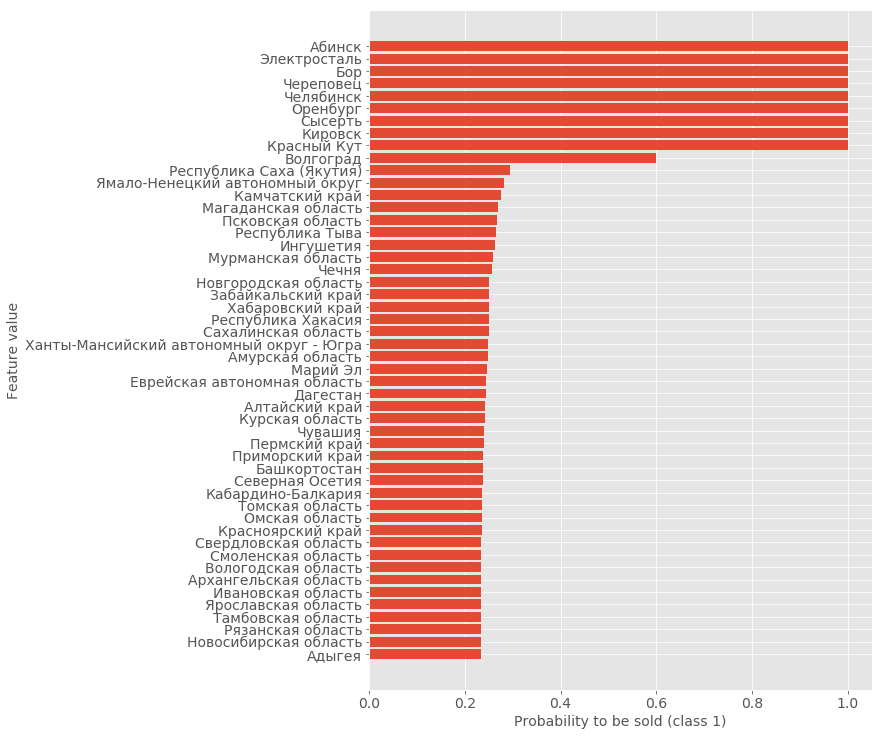

In [89]:
unique_values_bars(df_train, feature_name='region', n_top=50)

Number of unique values:  82


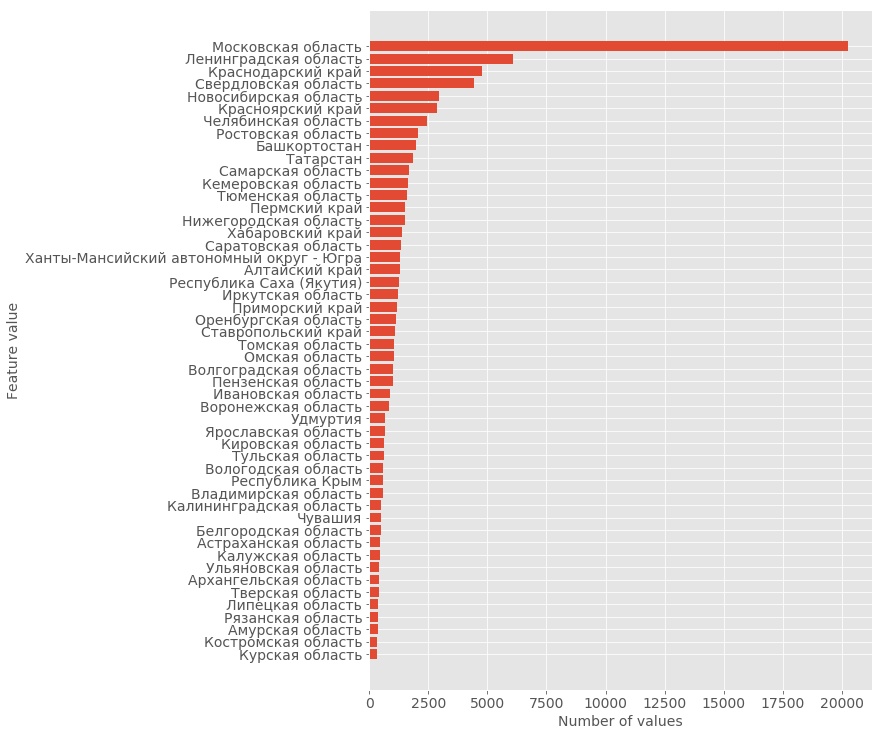

In [90]:
unique_values_bars(df_test, feature_name='region', n_top=50, with_sold_fast=False)

Не заметно особо связи региона с продаваемостью, но возьмем топ-10 в наш сет.

In [44]:
for feature_name in get_top_labels(df_train, 'region', 10):
    df_train_prep['region: ' + feature_name] = (df_train['region'] == feature_name).map(int)
    df_test_prep['region: ' + feature_name] = (df_test['region'] == feature_name).map(int)

### properties

Рассмотрим данное свойство повнимательнее позднее. Кажется, что в нем содержится слишком много уникальных значений и это не сыграет большой роли при классификации. 

Тем не менее мы можем разделить все объекты выборки на те, у которых данное свойство присутствует и те у которых оно пусто.

Данный вариант обработки фичи используется в каждой модели.

In [45]:
df_train_prep['properties'] = (df_train['properties'] != '[]').map(int)
df_test_prep['properties'] = (df_test['properties'] != '[]').map(int)

### product_type

Данный вариант обработки фичи используется в каждой модели.

Number of unique values:  3


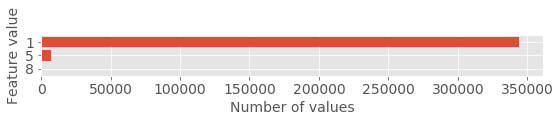

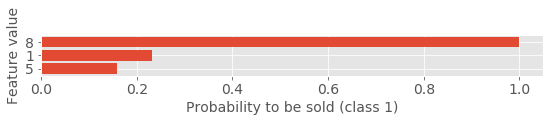

In [18]:
unique_values_bars(df_train, feature_name='product_type')

Number of unique values:  3


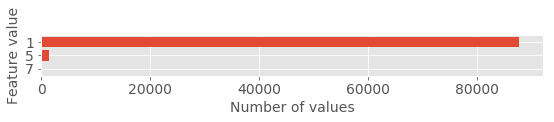

In [19]:
unique_values_bars(df_test, feature_name='product_type', with_sold_fast=False)

In [46]:
for feature_name in get_top_labels(df_train, 'product_type', 2):
    df_train_prep['product_type: ' + str(feature_name)] = (df_train['product_type'] == feature_name).map(int)
    df_test_prep['product_type: ' + str(feature_name)] = (df_test['product_type'] == feature_name).map(int)

### subcategory_id

Данный вариант обработки фичи используется в каждой модели.

Number of unique values:  281


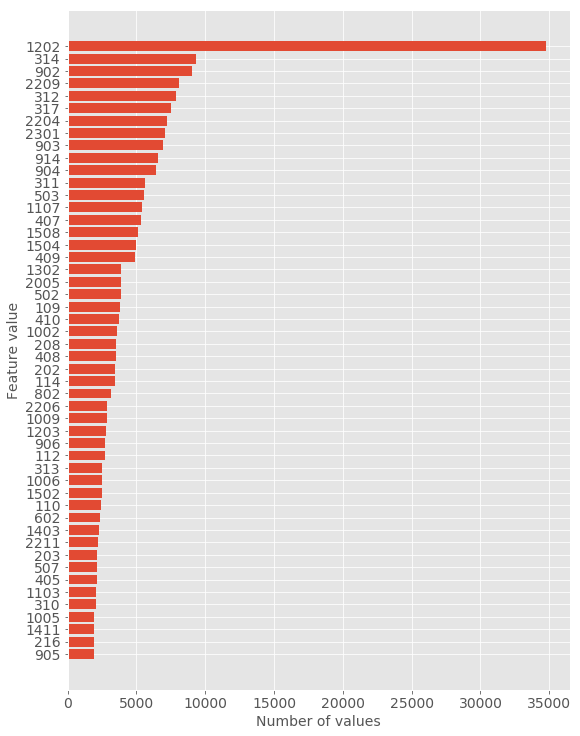

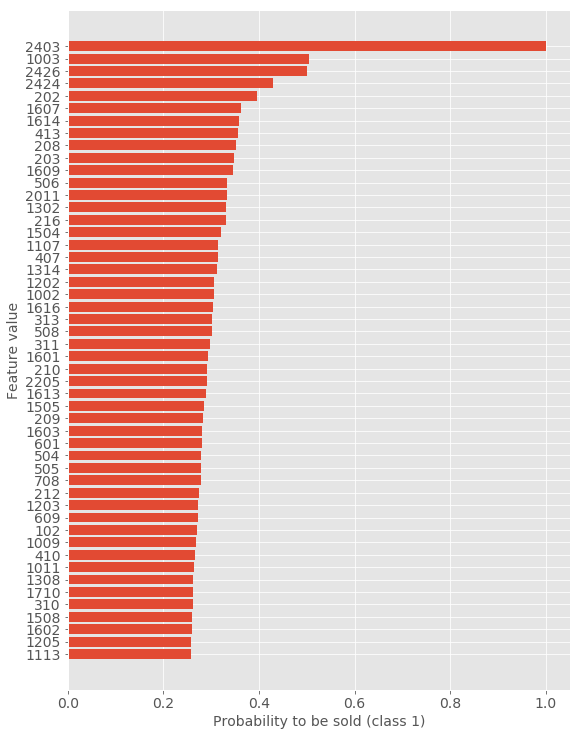

In [21]:
unique_values_bars(df_train, feature_name='subcategory_id', n_top=50)

Number of unique values:  273


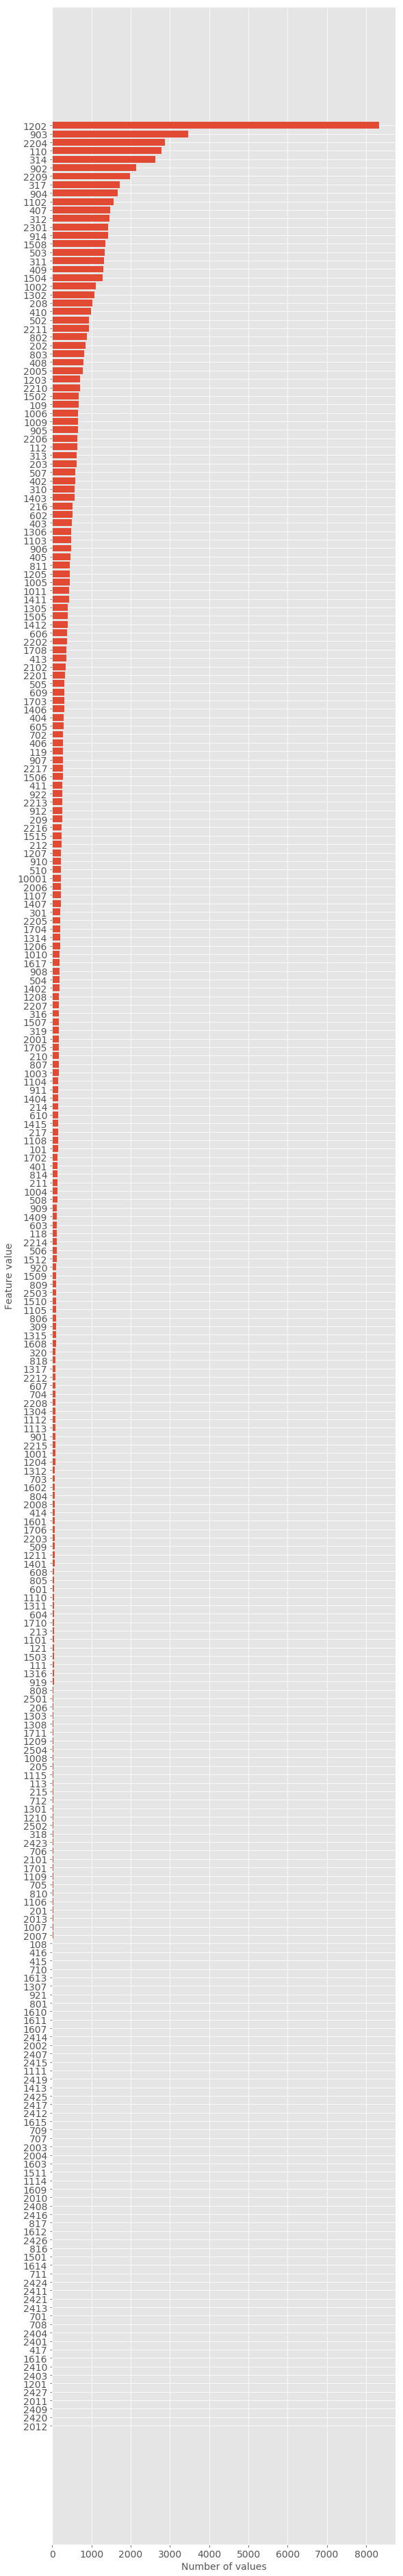

In [22]:
unique_values_bars(df_test, feature_name='subcategory_id', with_sold_fast=False)

In [47]:
for feature_name in get_top_labels(df_test, 'subcategory_id', 10):
    df_train_prep['subcategory_id: ' + str(feature_name)] = (df_train['subcategory_id'] == feature_name).map(int)
    df_test_prep['subcategory_id: ' + str(feature_name)] = (df_test['subcategory_id'] == feature_name).map(int)

### name_text

Поступим просто - каждое слово в вектор, если название состоит из нескольких слов - берем среднее. Данный код участвует не во всех решениях.

In [313]:
import gensim
w2v = gensim.models.Word2Vec.load('ru/ru.bin')

/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [328]:
vec_shape = (300)
def name_formatter(name):
    tokens = name.split(' ')
    res = 0
    n = 0
    for word in tokens:
        try:
            res += w2v.wv.get_vector(word)
            n += 1
        except KeyError:
            pass
    return res / n if n > 0 else np.zeros(vec_shape, dtype='float32')

In [334]:
names_train  = np.vstack(df_train['name_text'].map(name_formatter))

In [335]:
def add_vec_to_df(df, vec, name_prefix):
    vec = np.array(vec)
    for i in range(vec.shape[1]):
        df[name_prefix + str(i)] = vec[:, i]

In [394]:
add_vec_to_df(df_train_prep, names_train, 'name_ind: ')

Попробуем другие способы генерации векторов. Данный код участвует не во всех решениях.

In [377]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda.fit(names_train, df_train['sold_fast'])
names_train_lda = lda.transform(names_train)

In [378]:
add_vec_to_df(df_train_prep, names_train_lda, 'name_ind_lda: ')

In [344]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
names_train_reduced = pca.fit_transform(names_train)

In [351]:
names_test = np.vstack(df_test['name_text'].map(name_formatter))
names_test_reduced = pca.transform(names_test)

In [380]:
names_test_lda = lda.transform(names_test)

In [348]:
add_vec_to_df(df_train_prep, names_train_reduced, 'name_ind_pca: ')

Просто поанализируем названия.

Попробуем посмотреть какие слова в названии ускоряли продажу:

In [65]:
name_text_lens = df_train['name_text'].map(lambda name: len(name.split(' ')))

In [66]:
name_text_lens_1 = df_train[df_train['sold_fast'] == 1]['name_text'].map(lambda name: len(name.split(' ')))
y1 = []
for i in range(min(name_text_lens), max(name_text_lens) + 1):
    y1.append((name_text_lens_1 == i).sum())

In [67]:
name_text_lens_2 = df_train[df_train['sold_fast'] == 0]['name_text'].map(lambda name: len(name.split(' ')))
y2 = []
for i in range(min(name_text_lens), max(name_text_lens) + 1):
    y2.append((name_text_lens_2 == i).sum())

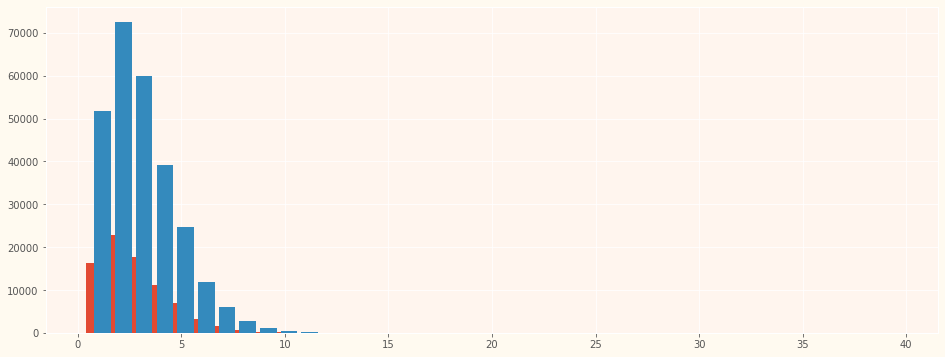

In [68]:
x1 = np.arange(min(name_text_lens), max(name_text_lens) + 1) - 0.2
x2 = np.arange(min(name_text_lens), max(name_text_lens) + 1) + 0.2

fig, ax = plt.subplots()

ax.bar(x1, y1)
ax.bar(x2, y2)

ax.set_facecolor('seashell')
fig.set_figwidth(16)
fig.set_figheight(6)
fig.set_facecolor('floralwhite')

plt.show()

Видно, что длина названия не влияла на скорость продажи.

In [80]:
import pymorphy2
from pymystem3 import Mystem

In [81]:
m = Mystem()

Installing mystem to /Users/arkazantseva/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-macosx.tar.gz


In [84]:
# Найдем какие леммы встречаются в какой группе.
lemmas_per_class = [{}, {}]
classes = [0,1]

for clas in classes:
    df_tmp = df_train[df_train['sold_fast'] == clas]
    for text in df_tmp['name_text']:
        tokens = m.lemmatize(text)
        for token in tokens:
            lemmas_per_class[clas][token] = lemmas_per_class[clas].setdefault(token, 0) + 1

In [86]:
# Оставим только леммы-существительные
morph = pymorphy2.MorphAnalyzer()

S_lemmas_per_class = [{},{}]

for clas in classes:
    for token in list(lemmas_per_class[clas].keys()):
        if morph.parse(token)[0].tag.POS == 'NOUN':
            S_lemmas_per_class[clas][token] = lemmas_per_class[clas][token]

In [98]:
most_fr_words = [None,None]
for clas in classes:
    list_d = list(S_lemmas_per_class[clas].items())
    list_d.sort(key=lambda i: -i[1])
    most_fr_words[clas] = list_d

In [112]:
uniq_sold = list(filter(lambda item: (item[0] not in list(dict(most_fr_words[0]).keys())), most_fr_words[1]))

In [113]:
uniq_sold

[('8мес', 4),
 ('чесалка', 4),
 ('донбасс', 3),
 ('коридорас', 3),
 ('мадем', 3),
 ('повторок', 3),
 ('дерт', 3),
 ('клумба', 3),
 ('ломо', 3),
 ('йорочка', 3),
 ('мираж', 3),
 ('эйдж', 3),
 ('электросковорода', 3),
 ('старатель', 3),
 ('француженка', 3),
 ('двухспалка', 3),
 ('блонда', 3),
 ('па', 3),
 ('2м10см', 2),
 ('бусин', 2),
 ('самсумг', 2),
 ('акито', 2),
 ('штерб', 2),
 ('ферзь', 2),
 ('слингуля', 2),
 ('3квт', 2),
 ('павел', 2),
 ('метабо', 2),
 ('4озу', 2),
 ('пангасиус', 2),
 ('михеев', 2),
 ('дубль', 2),
 ('электросушилка', 2),
 ('тугунок', 2),
 ('северск', 2),
 ('эксковатор', 2),
 ('макулатура', 2),
 ('аквалтис', 2),
 ('тунис', 2),
 ('калпак', 2),
 ('валлиснерия', 2),
 ('8озу', 2),
 ('живанш', 2),
 ('900г', 2),
 ('зверюшка', 2),
 ('джемини', 2),
 ('мишель', 2),
 ('котлета', 2),
 ('штопор', 2),
 ('петунья', 2),
 ('газплит', 2),
 ('прибой', 2),
 ('сеамский', 2),
 ('таксенок', 2),
 ('ростес', 2),
 ('тугунка', 2),
 ('термоголовка', 2),
 ('колоночка', 2),
 ('скриптонит', 2),


In [114]:
uniq_unsold = list(filter(lambda item: (item[0] not in list(dict(most_fr_words[1]).keys())), most_fr_words[0]))

In [115]:
uniq_unsold

[('анорак', 30),
 ('мутон', 28),
 ('помещение', 28),
 ('цилиндр', 26),
 ('рычаг', 25),
 ('обшивка', 22),
 ('швабра', 22),
 ('подошва', 19),
 ('маяк', 18),
 ('алгебра', 17),
 ('модулятор', 16),
 ('глюкометр', 16),
 ('победа', 16),
 ('полиция', 16),
 ('хойя', 16),
 ('стеклоподъемник', 16),
 ('остров', 15),
 ('фиксатор', 15),
 ('стоячок', 15),
 ('лакост', 15),
 ('люрекс', 15),
 ('топик', 15),
 ('шнурок', 14),
 ('поперечок', 14),
 ('гигиена', 14),
 ('оплетка', 14),
 ('челси', 14),
 ('блинница', 13),
 ('прокат', 13),
 ('регулятор', 13),
 ('прилавок', 13),
 ('пуговица', 13),
 ('консультант', 13),
 ('корабль', 13),
 ('букетик', 13),
 ('пион', 13),
 ('осанка', 12),
 ('раскраска', 12),
 ('топливо', 12),
 ('цивик', 12),
 ('знаток', 12),
 ('сокол', 12),
 ('горение', 12),
 ('отдельность', 12),
 ('удаление', 12),
 ('сауна', 12),
 ('косынка', 12),
 ('противотуманка', 12),
 ('веер', 11),
 ('вельвет', 11),
 ('саквояж', 11),
 ('акрил', 11),
 ('2013г', 11),
 ('календарь', 11),
 ('комбензон', 11),
 ('офо

In [118]:
most_fr_words_unsold_dict = dict(most_fr_words[0])

In [138]:
def s_proba(item):
    if item[0] not in list(dict(most_fr_words[0]).keys()):
        return (item[0], 1,0, item[1])
    count = item[1] + most_fr_words_unsold_dict[item[0]]
    return (item[0], item[1] / count, most_fr_words_unsold_dict[item[0]], item[1])

sold_proba = list(map(s_proba, most_fr_words[1]))

In [142]:
def get_fast(item):
    res = (item[1] > 0.6) and ((item[2] + item[3]) > 3) and (item[2] != 0)
    return res


notuniq_sold = list(filter(get_fast, sold_proba))
notuniq_sold

[('кефир', 0.6086956521739131, 9, 14),
 ('парус', 0.631578947368421, 7, 12),
 ('30кг', 0.7272727272727273, 3, 8),
 ('окей', 0.6153846153846154, 5, 8),
 ('использование', 0.6363636363636364, 4, 7),
 ('телек', 0.6363636363636364, 4, 7),
 ('тюмень', 0.75, 2, 6),
 ('хололильник', 0.8571428571428571, 1, 6),
 ('ригга', 0.75, 2, 6),
 ('технониколь', 0.6666666666666666, 3, 6),
 ('данио', 0.75, 2, 6),
 ('микровалновка', 0.6666666666666666, 3, 6),
 ('центрифуга', 0.75, 2, 6),
 ('фифа', 0.6666666666666666, 3, 6),
 ('микк', 0.8571428571428571, 1, 6),
 ('256гб', 0.625, 3, 5),
 ('1000гб', 0.625, 3, 5),
 ('линия', 0.625, 3, 5),
 ('швеллер', 0.6666666666666666, 2, 4),
 ('стрит', 0.8, 1, 4),
 ('витек', 0.6666666666666666, 2, 4),
 ('микросистема', 0.6666666666666666, 2, 4),
 ('афон', 0.8, 1, 4),
 ('выгул', 0.6666666666666666, 2, 4),
 ('комбат', 0.6666666666666666, 2, 4),
 ('автоподзавод', 0.8, 1, 4),
 ('электровеник', 0.8, 1, 4),
 ('чих', 0.8, 1, 4),
 ('поссум', 0.6666666666666666, 2, 4),
 ('ольга', 0.8

Здесь мы посторались проанализировать слова, которые встречаются в названии. Вывели существительные, встречаемость которых увеличивает шанс продажи uniq_sold, notuniq_sold, и существительные, которые скорее всего влияют на продажу отрицательно uniq_unsold.

Позднее мы эти знания применим к результатам работы нашей модели, в первом случае повышая вероятность, а во втором понижая.

In [144]:
positive_S_for_names = list(map(lambda item: item[0], notuniq_sold)) + list(map(lambda item: item[0], uniq_sold))

In [145]:
negative_S_for_names = list(map(lambda item: item[0], uniq_unsold))

Выше мы произвели анализ только существительных. Попробуем то же сделать с прилагательными и наречиями.

In [147]:
morph = pymorphy2.MorphAnalyzer()

A_lemmas_per_class = [{},{}]

for clas in classes:
    for token in list(lemmas_per_class[clas].keys()):
        if morph.parse(token)[0].tag.POS == 'ADJF' or morph.parse(token)[0].tag.POS == 'ADJS' or morph.parse(token)[0].tag.POS == 'COMP' or morph.parse(token)[0].tag.POS == 'PRTF' or morph.parse(token)[0].tag.POS == 'PRTS' or morph.parse(token)[0].tag.POS == 'ADVB':
            A_lemmas_per_class[clas][token] = lemmas_per_class[clas][token]

In [148]:
most_fr_a_words = [None,None]
for clas in classes:
    list_d = list(A_lemmas_per_class[clas].items())
    list_d.sort(key=lambda i: -i[1])
    most_fr_a_words[clas] = list_d

In [149]:
uniq_sold_a = list(filter(lambda item: (item[0] not in list(dict(most_fr_a_words[0]).keys())), most_fr_a_words[1]))
uniq_sold_a

[('клеевой', 4),
 ('графитовый', 3),
 ('подвижный', 3),
 ('практический', 2),
 ('кремлевский', 2),
 ('одноядерный', 2),
 ('двухполозный', 2),
 ('генетический', 2),
 ('владимирский', 2),
 ('шитый', 2),
 ('терапевтический', 2),
 ('ведущий', 2),
 ('двухуровневый', 2),
 ('рейдовый', 2),
 ('мандариновый', 2),
 ('бычий', 2),
 ('амистар', 2),
 ('трехрожковый', 2),
 ('двухдверный', 2),
 ('элекрический', 2),
 ('ожиреловый', 2),
 ('полуакустический', 2),
 ('чехословацкий', 1),
 ('малюсенький', 1),
 ('трогательный', 1),
 ('способный', 1),
 ('чипованый', 1),
 ('аккуститеский', 1),
 ('150мбит', 1),
 ('террано', 1),
 ('закрепочный', 1),
 ('2штоковый', 1),
 ('антипригарный', 1),
 ('феолетовый', 1),
 ('сфинксо', 1),
 ('мультискоростной', 1),
 ('ракообразный', 1),
 ('развадный', 1),
 ('реалистичный', 1),
 ('квартальный', 1),
 ('крапленый', 1),
 ('противоварикозный', 1),
 ('истремный', 1),
 ('акрилловый', 1),
 ('зимняч', 1),
 ('влаговпитывающий', 1),
 ('гостовский', 1),
 ('бескулерный', 1),
 ('акуумулят

In [150]:
uniq_unsold_a = list(filter(lambda item: (item[0] not in list(dict(most_fr_a_words[1]).keys())), most_fr_a_words[0]))
uniq_unsold_a

[('слитный', 38),
 ('бордовый', 22),
 ('танцевальный', 17),
 ('сам', 17),
 ('кроссовый', 15),
 ('реечный', 14),
 ('сиреневый', 14),
 ('клевый', 14),
 ('куриный', 13),
 ('сортовый', 13),
 ('интимный', 13),
 ('уютный', 13),
 ('грязевой', 12),
 ('алюминевый', 12),
 ('циркуляционный', 12),
 ('испанский', 12),
 ('барабанный', 12),
 ('одноместный', 12),
 ('шрус', 11),
 ('шарнирный', 11),
 ('ленточный', 11),
 ('древний', 11),
 ('именной', 11),
 ('мята', 10),
 ('кавказский', 10),
 ('памятный', 10),
 ('вьетнамский', 10),
 ('диодный', 10),
 ('резной', 10),
 ('одеялко', 10),
 ('главный', 10),
 ('переходный', 9),
 ('выхлопной', 9),
 ('деловой', 9),
 ('полипропиленовый', 9),
 ('бибо', 9),
 ('прицепной', 9),
 ('гребной', 9),
 ('скандинавский', 8),
 ('фотоапарат', 8),
 ('бриллиантовый', 8),
 ('тихий', 8),
 ('родословная', 8),
 ('импульсный', 8),
 ('солдатский', 8),
 ('ярко', 8),
 ('эластичный', 8),
 ('двухкомфорочный', 8),
 ('овечий', 8),
 ('кондитерский', 8),
 ('необходимый', 8),
 ('жирный', 8),
 ('

In [156]:
def a_proba(item):
    if item[0] not in list(dict(most_fr_a_words[0]).keys()):
        return (item[0], 1,0, item[1])
    count = item[1] + most_fr_words_unsold_dict_a[item[0]]
    return (item[0], item[1] / count, most_fr_words_unsold_dict_a[item[0]], item[1])

most_fr_words_unsold_dict_a = dict(most_fr_a_words[0])
sold_proba_a = list(map(a_proba, most_fr_a_words[1]))

In [158]:
notuniq_sold_a = list(filter(get_fast, sold_proba_a))
notuniq_sold_a

[('елочный', 0.6666666666666666, 5, 10),
 ('юный', 0.7, 3, 7),
 ('твердотельный', 0.75, 2, 6),
 ('различный', 0.7142857142857143, 2, 5),
 ('мортал', 0.6666666666666666, 2, 4),
 ('бутылочный', 0.6666666666666666, 2, 4),
 ('ногтевой', 0.6666666666666666, 2, 4),
 ('хорош', 0.8, 1, 4),
 ('пристенный', 0.75, 1, 3),
 ('зарубежный', 0.75, 1, 3),
 ('двухядерный', 0.75, 1, 3),
 ('куханный', 0.75, 1, 3),
 ('самодельный', 0.75, 1, 3),
 ('автономный', 0.75, 1, 3),
 ('форфоровый', 0.75, 1, 3),
 ('активаторный', 0.75, 1, 3),
 ('русско', 0.75, 1, 3)]

In [159]:
positive_A_for_names = list(map(lambda item: item[0], notuniq_sold_a)) + list(map(lambda item: item[0], uniq_sold_a))
negative_A_for_names = list(map(lambda item: item[0], uniq_unsold_a))

Спойлер: ничего хорошего из уникальных, частопродаваемых названий достать не получилось:(

### desc_text

При работе с описанием попробуем использовать несколько способов классификации чисто по описанию - обычный пайплайн, пайплайн с понижением размерности, fasttext и CNN разных архитектур. Результаты этих классификаций запишем и далее будем применять один из них в качестве столбика в основных данных.

In [269]:
def get_desc_with_name(df):
    return "NAME " + df['name_text'] + ' ' + df['desc_text']


X_NLP = get_desc_with_name(df_train)
y_NLP = df_train['sold_fast']

X_train_NLP, X_test_NLP, y_train_NLP, y_test_NLP = train_test_split(X_NLP, y_NLP, test_size=0.25, random_state=42)

In [107]:
vect = CountVectorizer()
tfidf = TfidfTransformer()
clf = RandomForestClassifier(random_state=122)

pipeline = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('clf', clf)
])

pipeline.fit(X_train_NLP, y_train_NLP)

y_pred_NLP = pipeline.predict(X_test_NLP)

/Users/arkazantseva/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy 0.7581584327527755


Recall 0 	 0.9738081356236264
Recall 1 	 0.038750701327847394


Precision 0 	 0.7716679549715241
Precision 1 	 0.30723606168446027


F-мера [0.86103332 0.0688212 ]


Матрица ошибок:


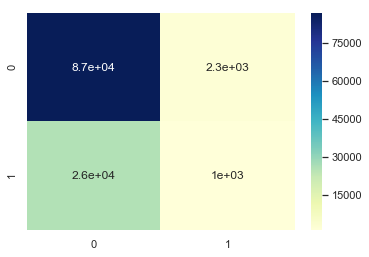

In [114]:
estimate_result(y_test_NLP, y_pred_NLP)

Ничего хорошего не видно. Посмотрим как повлияет уменьшение размерности

In [119]:
vect = CountVectorizer()
tfidf = TfidfTransformer()
clf = RandomForestClassifier(random_state=122)
reduce_dim = TruncatedSVD(n_components=50)

pipeline = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('reduce_dim', reduce_dim),
    ('clf', clf)
])

pipeline.fit(X_train_NLP, y_train_NLP)

y_pred_NLP = pipeline.predict(X_test_NLP)

/Users/arkazantseva/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy 0.7500237226434788


Recall 0 	 0.9565860878145042
Recall 1 	 0.06093136338133533


Precision 0 	 0.7726358877759867
Precision 1 	 0.2961279767315034


F-мера [0.85482691 0.10106713]


Матрица ошибок:


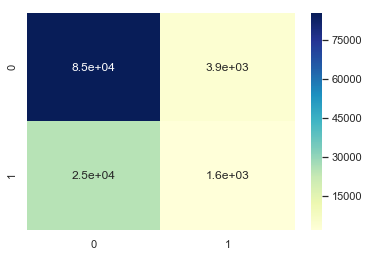

In [120]:
estimate_result(y_test_NLP, y_pred_NLP)

Результат почти не ухудшился, но работать стало всё заметно быстрее поиграем с параметрами:

* Классификаторы
    * MLPClassifier - лучше RandomForestClassifier
    * KNeighborsClassifier - не дает хороших результатов
    * RandomForestClassifier - дает хороший результат
    * QuadraticDiscriminantAnalysis - лучший результат
* Количество компонент после уменьшения размерности
    * 100 - качество не растет, а вот время да
    * 20 - заметно ухудшается качество
    
Некоторые проверки осуществлялись в других тетрадках - прилагаю скриншоты с их результатами.
Остальные проверки ниже.

In [122]:
vect = CountVectorizer()
tfidf = TfidfTransformer()
clf = KNeighborsClassifier()
reduce_dim = TruncatedSVD(n_components=50)

pipeline = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('reduce_dim', reduce_dim),
    ('clf', clf)
])

pipeline.fit(X_train_NLP, y_train_NLP)

y_pred_NLP = pipeline.predict(X_test_NLP)

Accuracy 0.7299673058840782


Recall 0 	 0.916771314526618
Recall 1 	 0.10678885356274546


Precision 0 	 0.7739599602442141
Precision 1 	 0.2777777777777778


F-мера [0.8393342  0.15427012]


Матрица ошибок:


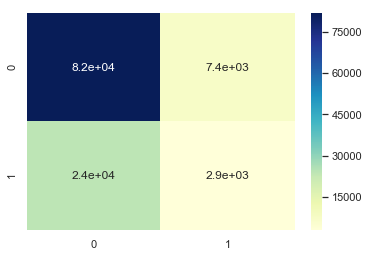

In [123]:
estimate_result(y_test_NLP, y_pred_NLP)

CNN preproc

In [274]:
NUM_WORDS = 10000
EMB_SIZE = 100

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(pd.concat([X_train_NLP, X_test_NLP, df_test['desc_text']], axis=0))

from itertools import cycle, count


X_train_CNN = cycle(tokenizer.texts_to_sequences_generator(X_train_NLP))    
X_test_CNN = tokenizer.texts_to_sequences(X_test_NLP)
    
y_train_CNN = cycle(y_train_NLP)
y_test_CNN = y_test_NLP

from tensorflow.keras.preprocessing.sequence import pad_sequences

def iterate_minibatches(X, y, batch_size=30, return_y=True):
    X = iter(X)
    y = iter(y)
    
    batch = [[], []]
    try:
        for i in count():
            batch[0].append(next(X))
            batch[1].append(next(y))
            if len(batch[0]) == batch_size:
                batch[0] = pad_sequences(batch[0], padding='post')
                batch[1] = np.array(batch[1])
                if return_y:
                    yield batch[0], batch[1]
                else:
                    yield batch[0]
                batch = [[], []]
    except StopIteration:
        batch[0] = pad_sequences(batch[0], padding='post')
        batch[1] = np.array(batch[1])
        if return_y:
            yield batch[0], batch[1]
        else:
            yield batch[0]


In [275]:
#load fasttext vectors
word_to_vec = {}
with open('embedding_model.vec') as ft:
    for i, line in enumerate(ft):
        if i == 0:
            continue
        split = line.strip().split(' ')
        word = split[0]
        vec = np.array([float(x) for x in split[1:]])
        word_to_vec[word] = vec

embedding_matrix = np.zeros((NUM_WORDS, EMB_SIZE))

oov = 0
for ind, word in tokenizer.index_word.items():
    if ind < NUM_WORDS:
        if word in word_to_vec:
            embedding_matrix[ind] = word_to_vec[word]
        else:
            oov += 1
        
oov

5120

CNN

In [413]:
from tensorflow import keras

In [492]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Activation, GlobalMaxPool1D, Dense, Embedding

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=NUM_WORDS, output_dim=EMB_SIZE, weights=[embedding_matrix]))
cnn_model.add(keras.layers.Conv1D(20, 3, ))
cnn_model.add(keras.layers.Activation("relu"))
cnn_model.add(keras.layers.GlobalMaxPool1D(name="out_pool"))
cnn_model.add(keras.layers.Dense(1))
cnn_model.add(keras.layers.Activation('sigmoid'))

In [493]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [494]:
cnn_hid_model = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('out_pool').output)


In [495]:
batch_size = 100
cnn_model.fit_generator(
    iterate_minibatches(X_train_CNN, y_train_CNN, batch_size=batch_size),
    int(np.ceil(X_train.shape[0]/ batch_size)) , 
    epochs=1)

2986/2986 [==============================] - 124s 42ms/step - loss: 0.5287 - acc: 0.7684


In [496]:
def predict_cnn_features(txt):
    txt = tokenizer.texts_to_sequences(txt)
    return cnn_hid_model.predict_generator(
        iterate_minibatches(txt, txt, batch_size=10, return_y=False),
        int(np.ceil(len(txt) / 10)))


In [497]:
def predict_cnn_probas(txt):
    txt = tokenizer.texts_to_sequences(txt)
    return cnn_model.predict_generator(
        iterate_minibatches(txt, txt, batch_size=10, return_y=False),
        int(np.ceil(len(txt) / 10)))


In [498]:

y_pred_CNN = cnn_model.predict_generator(
    iterate_minibatches(X_test_CNN, y_test_CNN, batch_size=10, return_y=False),
    int(np.ceil(len(X_test_CNN) / 10)))



In [499]:
#estimate_result(y_test_CNN, y_pred_CNN)
roc_auc_score(y_test_CNN, y_pred_CNN)

0.6115653875717375

Accuracy 0.685656050375195


Recall 0 	 0.8029673853610959
Recall 1 	 0.291732830488289


Precision 0 	 0.7919660685915842
Precision 1 	 0.30600666250260256


F-мера [0.79742879 0.29869932]


Матрица ошибок:


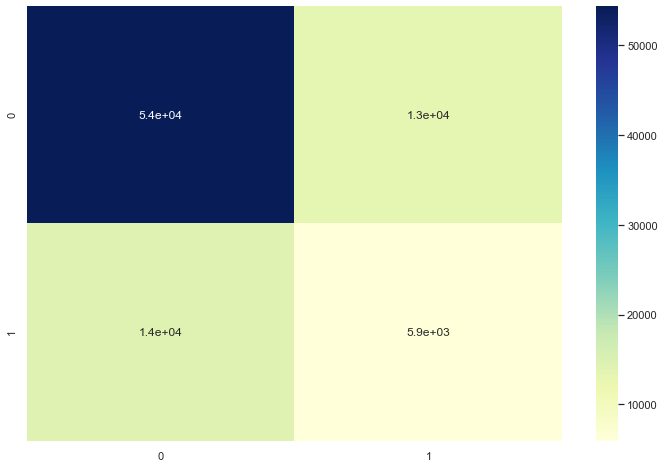

In [192]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
vect = CountVectorizer()
tfidf = TfidfTransformer()
reduce_dim = TruncatedSVD(n_components=50)
clf = QuadraticDiscriminantAnalysis()

pipeline = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('reduce_dim', reduce_dim),
    ('clf', clf)
])

pipeline.fit(X_train_NLP, y_train_NLP)

y_pred_NLP = pipeline.predict(X_test_NLP)

estimate_result(y_test_NLP, y_pred_NLP)

In [194]:
y_pred_proba_NLP = pipeline.predict_proba(X_test_NLP)

In [195]:
roc_auc_score(y_test_NLP, list(map(lambda x: x[1], y_pred_proba_NLP)))

0.5744559835254871

А сейчас испробуем fasttext на данном сете.

In [124]:
!wget https://github.com/facebookresearch/fastText/archive/v0.2.0.zip

--2019-06-08 15:39:31--  https://github.com/facebookresearch/fastText/archive/v0.2.0.zip
Распознаётся github.com (github.com)… 140.82.118.4
Подключение к github.com (github.com)|140.82.118.4|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 
  HTTP/1.1 302 Found
  Date: Sat, 08 Jun 2019 12:39:32 GMT
  Content-Type: text/html; charset=utf-8
  Transfer-Encoding: chunked
  Server: GitHub.com
  Status: 302 Found
  Vary: X-PJAX
  Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.2.0
  Cache-Control: max-age=0, private
  Set-Cookie: has_recent_activity=1; path=/; expires=Sat, 08 Jun 2019 13:39:31 -0000
  Set-Cookie: logged_in=no; domain=.github.com; path=/; expires=Wed, 08 Jun 2039 12:39:32 -0000; secure; HttpOnly
  Set-Cookie: _gh_sess=dUtOeHAxb09LdFNyWnJ6dXZLR0pCWEZEOXAydkdYT0hVVm55YzNscWh3RXhtczdsc0hPRDg1SlBCK2VBV1U1TDY3anpubzhMUTB4dWo1SWgwK3F0dXJudFJPZkpsRWtnVFpJcDZFK0dDWG16bVhmVkRTVzZad0p5UXc4UjNGLyt1SmtCcTNEbVBPN1BEOHZ0ZEQxSFE3ckxOdmNjMVNvb3ZL

In [125]:
!unzip v0.2.0

Archive:  v0.2.0
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-0.2.0/.circleci/
  inflating: fastText-0.2.0/.circleci/cmake_test.sh  
  inflating: fastText-0.2.0/.circleci/config.yml  
  inflating: fastText-0.2.0/.circleci/gcc_test.sh  
  inflating: fastText-0.2.0/.circleci/pip_test.sh  
  inflating: fastText-0.2.0/.circleci/pull_data.sh  
  inflating: fastText-0.2.0/.circleci/python_test.sh  
  inflating: fastText-0.2.0/.circleci/run_locally.sh  
  inflating: fastText-0.2.0/.circleci/setup_circleimg.sh  
  inflating: fastText-0.2.0/.circleci/setup_debian.sh  
  inflating: fastText-0.2.0/.gitignore  
  inflating: fastText-0.2.0/CMakeLists.txt  
  inflating: fastText-0.2.0/CONTRIBUTING.md  
  inflating: fastText-0.2.0/LICENSE  
  inflating: fastText-0.2.0/MANIFEST.in  
  inflating: fastText-0.2.0/Makefile  
  inflating: fastText-0.2.0/README.md  
   creating: fastText-0.2.0/alignment/
  inflating: fastText-0.2.0/alignment/README.md  
  infla

  inflating: fastText-0.2.0/website/static/docs/en/html/functions_s.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/functions_t.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/functions_u.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/functions_v.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/functions_vars.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/functions_w.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/functions_z.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/globals.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/globals_defs.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/globals_func.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/index.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/jquery.js  
  inflating: fastText-0.2.0/website/static/docs/en/html/main_8cc.html  
  inflating: fastText-0.2.0/website/stat

  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_3.js  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_4.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_4.js  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_5.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_5.js  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_6.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_6.js  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_7.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_7.js  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_8.html  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_8.js  
  inflating: fastText-0.2.0/website/static/docs/en/html/search/variables_9.html  
  inflating: fastText-0.2.0/

In [126]:
!cd fastText-0.2.0; make

c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/args.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/dictionary.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/productquantizer.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/matrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/qmatrix.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/vector.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/model.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/utils.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/meter.cc
c++ -pthread -std=c++0x -march=native -O3 -funroll-loops -c src/fasttext.cc
src/fasttext.cc:302:16: warning: 'selectEmbeddings' is deprecated:
      selectEmbeddings is being deprecated. [-Wdeprecated-declarations]
    auto idx = selectEmbeddings(qargs.cutoff);
               ^
src/fasttext.h:168:3: note: 'selectEmbeddings

In [128]:
train_fasttext = pd.DataFrame(data={'text': X_train_NLP, 'label': '__label__' + y_train_NLP.map(str)})
train_fasttext.to_csv('hope_it_works.txt', index=False, sep=' ', header=None)

In [129]:
!cd fastText-0.2.0; ./fasttext supervised -input ../hope_it_works.txt -output model

Read 5M words
Number of words:  578319
Number of labels: 2
Progress: 100.0% words/sec/thread:  994167 lr:  0.000000 loss:  0.510273 ETA:   0h 0m


In [132]:
test_fasttext = pd.DataFrame(data={'text': X_test_NLP, 'label': '__label__' + y_test_NLP.map(str)})

In [133]:
test_fasttext.to_csv('it_works.txt', sep=' ', header=None)

In [134]:
!cd fastText-0.2.0; ./fasttext test model.bin ../it_works.txt

N	115923
P@1	0.753
R@1	0.753


In [136]:
!cd fastText-0.2.0; ./fasttext predict model.bin ../it_works.txt >> y_pred.txt

In [137]:
y_pred = pd.read_csv('fastText-0.2.0/y_pred.txt', header=None)

Accuracy 0.7532845078198459


Recall __label__0 	 0.9586042965421357
Recall __label__1 	 0.06833738544978493


Precision __label__0 	 0.7743922321655012
Precision __label__1 	 0.33103823156368906


F-мера [0.85670768 0.11328827]


Матрица ошибок:


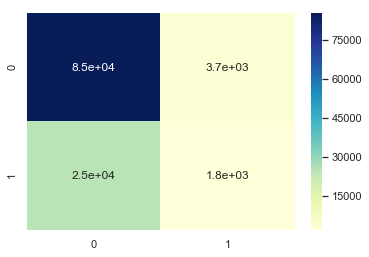

In [141]:
estimate_result_2('__label__' + y_test_NLP.map(str), y_pred_NLP[0], class_prefix = '__label__')

Далее в обучении моделей использовались векторы ответов QuadraticDiscriminantAnalysis и CNN нескольких архитектур, а также результат max_poolinga из CNN.

In [527]:
df_train_prep['desc'] = predict_cnn_probas(get_desc_with_name(df_train))
#add_vec_to_df(df_train_prep, predict_cnn_features(get_desc_with_name(df_train)), 'desc_features: ')

In [528]:
df_test_prep['desc'] = predict_cnn_probas(get_desc_with_name(df_test))
#add_vec_to_df(df_test_prep, predict_cnn_features(get_desc_with_name(df_test)), 'desc_features: ')

In [196]:
df_train_prep['desc'] = list(map(lambda x: x[1], pipeline.predict_proba(df_train['desc_text'])))

In [197]:
df_test_prep['desc'] = list(map(lambda x: x[1], pipeline.predict_proba(df_test['desc_text'])))

In [546]:
df_train_prep.to_csv('backup_train_7.csv')
df_test_prep.to_csv('backup_test_7.csv')

In [356]:
df_train_y.to_csv('backup_y_train.csv')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [540]:
X_train, X_test, y_train, y_test = train_test_split(df_train_prep, df_train_y, test_size=0.15, random_state=42)

# (almost) Zero-knowledge prediction
* Develop non-machine learning approach to get predictions
    * Describe it and measure its quality on Kaggle

Из таких методов можно попробовать присвоить самый частый класс (в нашем случае c верояностью - 0,5) всем объектам.

In [80]:
save_solution(df_test['product_id'], df_test['product_id'].map(lambda x: 0,5), 'const_sol.csv')

Public score на кегле: 0.50000

# Machine-learning pipeline and prediction

Here you develop your pipeline, generate features for train and test sets
* Your pipeline should be reproducible - make sure you set all `random_states` if needed

Попробуем самые простые модели, например LogisticRegression и RandomForestClassifier. Для описания используем  QuadraticDiscriminantAnalysis, для времени - время в днях от начала 2018, для названия - обычные вектора w2v.

In [82]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(random_state=34, solver='sag').fit(X_train, y_train)

/Users/arkazantseva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [86]:
y_pred = log_clf.predict_proba(X_test)

In [91]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, list(map(lambda x: x[0], y_pred)))

0.5013863499874633

In [105]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=124).fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
roc_auc_score(y_test, list(map(lambda x: x[1], y_pred)))

0.6035056918451643

In [106]:
save_solution(df_test['product_id'], list(map(lambda x: x[1], clf.predict_proba(df_test_prep))), 'forest.csv')

Лес Public score на кегле: 0.5908

Попробуем удалить признак имени из данных. Он получился не очень хорош, так как распознал мало слов и оставил много нулевых векторов.

In [181]:
for col in df_train_prep.columns:
    if 'name_ind: ' in col:
        del df_train_prep[col]
        del df_test_prep[col]

In [182]:
X_train, X_test, y_train, y_test = train_test_split(df_train_prep, df_train_y, test_size=0.33, random_state=145)

In [194]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=14).fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
roc_auc_score(y_test, list(map(lambda x: x[1], y_pred)))

0.6159261927089809

In [197]:
save_solution(df_test['product_id'], list(map(lambda x: x[1], clf.predict_proba(df_test_prep))), 'forest_2.csv')

Score: 0.60597

Следующий сет попыток.

Результаты экспериментов не сохранены, так как код писался поверх другого кода:( Это общая техника экспериментов, которые мы проводили после простых классификаторов:

    - набираем фичи
    - запускаем feature selection
    - обучаем XGBoost

In [160]:
from sklearn.model_selection import cross_validate

In [165]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)

In [166]:
selection_model = SelectFromModel(clf, prefit=True, threshold='0.17*mean')
X_train_new = selection_model.transform(X_train)
X_train_new.shape

(298588, 56)

In [180]:
import numpy as np
from sklearn.metrics import roc_auc_score
import xgboost

model = xgboost.XGBClassifier(
    eta=0.01, 
    max_depth=4, 
    min_child_weight=1.0, 
    n_estimators=300, 
    scale_pos_weight=1.0, 
    alpha=1.0, 
    tree_method='hist'
)
model.fit(X_train_new, np.ravel(y_train), verbose=1)
roc_auc_score(y_test, list(map(lambda x: x[1], model.predict_proba(selection_model.transform(X_test)))))

0.6133144609359186

На данных использующих оценку описания полученную  uadraticDiscriminantAnalysis:

In [531]:
X_train.head()

,img_num,lat,long,price,sold_mode,delivery_available,payment_available,category_id: 100,category_id: 25,category_id: 21,...,desc_features: 10,desc_features: 11,desc_features: 12,desc_features: 13,desc_features: 14,desc_features: 15,desc_features: 16,desc_features: 17,desc_features: 18,desc_features: 19
95741,1,48.4969,135.0700,8900.0,1,0,0,0,0,0,...,0.936977,0.708056,0.687303,0.086576,0.331243,0.516515,1.000250,0.249981,0.867186,0.659802
169041,4,55.8301,37.4931,21000.0,1,1,1,0,0,0,...,0.416736,0.075846,0.262233,-0.109169,-0.187771,0.310929,0.644754,0.082896,0.418134,0.189764
204402,3,55.9864,37.2021,150.0,1,0,0,0,0,0,...,0.304599,0.128282,0.422553,-0.038566,0.199897,0.348874,0.459438,0.177776,0.349642,0.236798
498272,1,53.8328,87.1727,1000.0,1,0,1,0,0,0,...,0.841733,0.109948,0.634853,-0.132327,0.059051,0.093393,0.760633,0.133726,0.364197,0.211822
195504,2,53.3345,83.6695,1500.0,1,0,0,0,0,0,...,0.563757,0.164755,0.902302,0.031394,0.178524,0.605977,0.492966,0.439021,0.267931,0.370388


In [532]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)

In [537]:
selection_model = SelectFromModel(clf, prefit=True, threshold='0.3*mean')
X_train_new = selection_model.transform(X_train)
X_train_new.shape

(298588, 93)

In [538]:
model = xgboost.XGBClassifier(
    learning_rate=0.05, 
    max_depth=5, 
    #min_child_weight=1.0, 
    n_estimators=500, 
    #scale_pos_weight=1.0, 
    alpha=10.0, 
    tree_method='hist',
    n_jobs=7,
    nthreads=7,
)
model.fit(X_train_new, np.ravel(y_train), verbose=1)
roc_auc_score(y_test, list(map(lambda x: x[1], model.predict_proba(selection_model.transform(X_test)))))

0.6195169522450298

In [545]:
# BEST SO FAR WITHOUT CNN FEATURES
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)

selection_model = SelectFromModel(clf, prefit=True, threshold='0.18*mean')
X_train_new = selection_model.transform(X_train)
X_train_new.shape

model = xgboost.XGBClassifier(
    learning_rate=0.05, 
    max_depth=5, 
    #min_child_weight=1.0, 
    n_estimators=500, 
    #scale_pos_weight=1.0, 
    alpha=10.0, 
    tree_method='hist',
    n_jobs=7,
    nthreads=7,
)
model.fit(X_train_new, np.ravel(y_train), verbose=1)
roc_auc_score(y_test, list(map(lambda x: x[1], model.predict_proba(selection_model.transform(X_test)))))

0.6237840849135542

In [543]:
y_pred = model.predict_proba(selection_model.transform(df_test_prep))

In [544]:
save_solution(df_test['product_id'],list(map(lambda x: x[1], y_pred)), 'my_xgboost4.csv')

# Model interpretation
Try to interpret your model results
* What **knowledge** does it reveal?

В лучшей посылке результат отбора фичей и выклад каждой фичи были сохранены как feature_imp.csv

In [3]:
feature_imp = pd.read_csv('./feature_imp.csv', index_col=0)

In [4]:
feature_imp

,imp
feature,
img_num,0.012598
lat,0.009622
long,0.010219
price,0.027424
sold_mode,0.012691
delivery_available,0.019265
payment_available,0.012794
category_id: 100,0.008387
category_id: 21,0.011595


In [9]:
feature_imp[feature_imp['imp'] > 0.015].sort_values(by=['imp'], ascending=False)

,imp
feature,
category_id: 2,0.074916
category_id: 9,0.056161
desc,0.051180
category_id: 22,0.049016
subcategory_id: 1202,0.044518
date_created,0.033518
category_id: 14,0.028382
category_id: 4,0.028084
price,0.027424


Видно, что из всех используемых признаков наиболее значимыми оказались: 
    - некоторые категории товаров (2,9,22,14,4,3,10,13,15,5,1)
    - поле desc - предобученный классификатор, базирующийся исключительно на описании. Он сам по себе имел неплохой скор и тут сослужил службу
    - price - очевидно
    - наличие дополнительных свойств товара - чем больше деталей о товаре мы знаем - тем охотнее купим
    - возможность доставки - тоже давольно очевидно

Рассмотрим повнимательнее категории

Всего существует 24 категории из которых 11 попали в список самых влиятельных параметров (все они входят в топ-12 по частоте объявлений):

    - 2 - бытовая техника
    - 9 - одежда
    - 22 - одежда и обувь 
    - 14 - красота и здоровье
    - 4 - мебель
    - 3 - товары для детей
    - 10 - хобби-товары
    - 13 - телевизоры и прочая техника
    - 15 - ноутбуки пк и прочее
    - 5 - питомцы
    - 1 - автомобильные товары
    
12,11,8,6,23,20,17,16,7,21,25,100,24 - не вошли в топ по влиянию на модель. Среди этих категорий есть услуги, недвижимость, автомобили. Эти категории точно продаются реже, стоят дороже и покупаются осмысленнее, чем одежда и косметика.

Number of unique values:  24


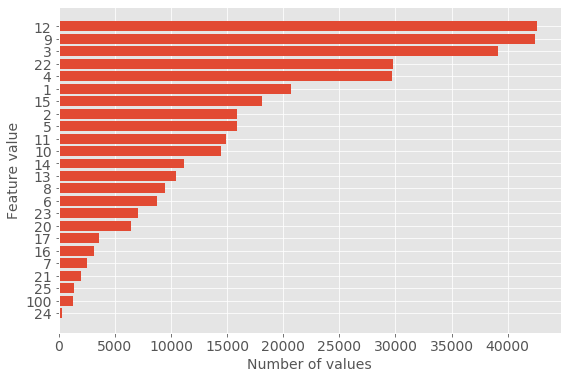

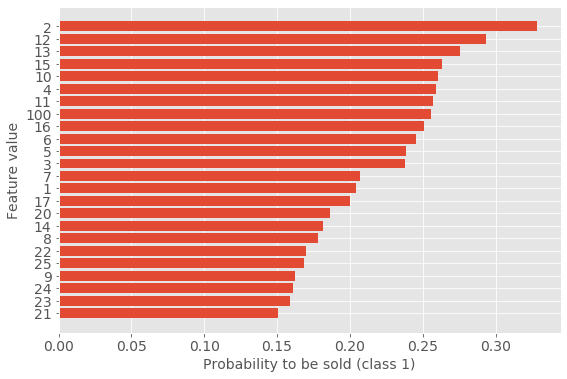

In [14]:
unique_values_bars(df_train, feature_name='category_id')

In [18]:
for i in [2,9,22,14,4,3,10,13,15,5,1]:
    print('\n', i, '\n')
    print(df_train[df_train['category_id'] == i]['name_text'].head()) 


 2 

15                           Холодильники бу
16               Стиральная машина LG 5,5 кг
39     Продам 2х камерный холодильник Stinol
235          Стиральная машина Славда WS-50P
291                              Термочайник
Name: name_text, dtype: object

 9 

4                                        Костюм
37     Бюстгальтер чёрный для кормящей мамочки 
48                            трусики кружевные
71                                Продам костюм
125                                    Платье S
Name: name_text, dtype: object

 22 

26     Ботинки демисезонные 22 р
38      Сабо Crocs 24 размер 8/9
63               Платье нарядное
85    Полукомбез в отл.состоянии
93                       Сандали
Name: name_text, dtype: object

 14 

70                                  Обувь Барука
100                               Матовая помада
132    Бальзам спрей для волос малина и гибискус
183        Туалетная вода Sparkly Citrus от Avon
246                             Парфюмерная вода
Name: 

In [19]:
for i in [12,11,8,6,23,20,17,16,7,21,25,100,24]:
    print('\n', i, '\n')
    print(df_train[df_train['category_id'] == i]['name_text'].head()) 


 12 

41     iPhone 6 space gray 32Gb
61          iPhone 6 64Gb Gold 
77      iPhone 7 32 GB в идеале
99               LG K5 Dual sim
101                Fly nimbus 7
Name: name_text, dtype: object

 11 

11                  Велосипед детский
24    Палки для трекинга appernaz 200
28             Spyderco, складной нож
74                            Протеин
78                  Детский велосипед
Name: name_text, dtype: object

 8 

52                                 Сапоги Lemigo Worker
67                                            Бейсболка
113    Фирменная зимняя куртка на мужчину или школьника
166                                        Штаны Reebok
191                                   Лонгслив размер S
Name: name_text, dtype: object

 6 

25                                 Тренога для стойки
60                                     Балконный блок
65                            патроны для шуруповерта
200    Циркулярка фуганок деревообрабатывающий станок
201                                